In [0]:
import os
import cv2
import torch
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms, datasets, utils

In [2]:
train_data = datasets.MNIST('MNIST', train = True, 
                         transform = transforms.Compose([transforms.ToTensor()]),
                         download = True)

train_batch = torch.utils.data.DataLoader(train_data, batch_size = 100, shuffle = True)

Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw


Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!


In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print(torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
    print("Running on cpu")




Tesla P100-PCIE-16GB


In [0]:
def latent_space_vectors(size): #size is the number of samples in a batch
    return torch.randn(size, 100, 1, 1).to(device)

def real_data_target(size):
    return (torch.ones(size)).to(device)

def fake_data_target(size):
    return (torch.zeros(size)).to(device)

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convT1 = nn.ConvTranspose2d(100, 128, kernel_size = 3, stride = 1, padding = 0)
        self.batch_norm1 = nn.BatchNorm2d(128)
        
        self.convT1_labels = nn.ConvTranspose2d(10, 128, kernel_size = 3, stride = 1, padding = 0)
        self.batch_norm1_labels = nn.BatchNorm2d(128)
        
        self.convT2 = nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, padding = 0)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.convT3 = nn.ConvTranspose2d(128, 64, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.convT4 = nn.ConvTranspose2d(64, 1, kernel_size = 4, stride = 2, padding = 1)
        
    def forward(self, x, y):
        x = self.convT1(x)
        x = F.relu(self.batch_norm1(x))
        
        y = self.convT1_labels(y.view(100, 10, 1, 1))
        y = F.relu(self.batch_norm1_labels(y))
        
        x = torch.cat((x,y), 1)
        x = self.convT2(x)
        x = F.relu(self.batch_norm2(x))
        x = self.convT3(x)
        x = F.relu(self.batch_norm3(x))
        x = self.convT4(x)
        return x

In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size = 4, stride = 2, padding = 1)
        
        self.conv1_labels = nn.Conv2d(10, 16, kernel_size = 4, stride = 2, padding = 1)
        
        self.conv2 = nn.Conv2d(24, 64, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm1 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 4, stride = 2, padding = 1)
        self.batch_norm2 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 1, kernel_size = 4, stride = 2, padding = 1)
        #self.batch_norm3 = nn.BatchNorm2d(256)
        #self.conv5 = nn.Conv2d(256, 1, kernel_size = 2, stride = 1, padding = 0) #4,1,0
        
    def forward(self, x, y):
        x = self.conv1(x)
        x = F.leaky_relu(x, 0.2)
        y = self.conv1_labels(y)
        y = F.leaky_relu(y, 0.2)
        x = torch.cat((x, y), 1)
        x = self.conv2(x)
        x = F.leaky_relu(self.batch_norm1(x), 0.2)
        x = self.conv3(x)
        x = F.leaky_relu(self.batch_norm2(x), 0.2)
        x = self.conv4(x)
        #x = F.leaky_relu(self.batch_norm3(x), 0.2)
        #x = self.conv5(x)
        x = torch.sigmoid(x)
        return x

In [0]:
generator = Generator()
discriminator = Discriminator()
generator.to(device)
discriminator.to(device)
loss_function = torch.nn.BCELoss()
optimizer_generator = optim.Adam(generator.parameters(), lr = 0.0002)
optimizer_discriminator = optim.Adam(discriminator.parameters(), lr = 0.0002)

In [0]:
def one_hot_encoder(labels, num_labels):
    batch_size = len(labels)
    one_hot_labels = torch.zeros([batch_size, num_labels])
    for i in range(batch_size):
        one_hot_labels[i][labels[i]] = 1
    return one_hot_labels

In [0]:
def train_generator(fake_image, fake_image_labels):
    generator.zero_grad()
    
    prediction_fake_image = discriminator.forward(fake_image, fake_image_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, real_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    optimizer_generator.step()
    
    return loss_fake_image

In [0]:
def train_discriminator(real_image, fake_image, real_labels, fake_labels):
    discriminator.zero_grad()
    
    #train on real images
    prediction_real_image = discriminator.forward(real_image, real_labels).view(100)
    loss_real_image = loss_function(prediction_real_image, real_data_target(prediction_real_image.size(0)))
    loss_real_image.backward()
    
    #train on fake images
    prediction_fake_image = discriminator.forward(fake_image, fake_labels).view(100)
    loss_fake_image = loss_function(prediction_fake_image, fake_data_target(prediction_fake_image.size(0)))
    loss_fake_image.backward()
    
    optimizer_discriminator.step()
    
    return loss_real_image + loss_fake_image, prediction_real_image, prediction_fake_image

In [11]:
EPOCHS = 20

for i in range(EPOCHS):
    for real_batch, labels in tqdm(train_batch):
        
        real_image = real_batch.to(device)#real image batch 100        
        
        real_image_labels_d = torch.zeros(100, 10, 28, 28).to(device)#into discriminator
        fake_image_labels_d = torch.zeros(100, 10, 28, 28).to(device)#into discriminator
        fake_image_labels_g = torch.zeros(100, 10).to(device)#into generator
        
        for j in range(100):
            real_image_labels_d[j][labels[j]] = 1
            fake_image_labels_d[j][labels[j]] = 1
            fake_image_labels_g[j][labels[j]] = 1
            
            
        fake_image = generator.forward(latent_space_vectors(100), fake_image_labels_g).to(device)
        d_error, d_pred_real, d_pred_fake = train_discriminator(real_image, fake_image, real_image_labels_d, fake_image_labels_d)
        
        
        
        fake_image = generator.forward(latent_space_vectors(100), fake_image_labels_g)
        g_error = train_generator(fake_image, fake_image_labels_d)
        
    print('Epoch = '+ str(i) + " Discriminator loss = " + str(d_error.data.cpu().numpy()) + " Generator loss = " + str(g_error.data.cpu().numpy()))

  0%|          | 2/600 [00:00<00:30, 19.86it/s]

Epoch = 0 Discriminator loss = 0.12571955 Generator loss = 4.608127


  0%|          | 3/600 [00:00<00:28, 21.23it/s]

Epoch = 1 Discriminator loss = 0.31153965 Generator loss = 3.1412873


  0%|          | 2/600 [00:00<00:32, 18.49it/s]

Epoch = 2 Discriminator loss = 0.15574077 Generator loss = 3.8402362


  0%|          | 2/600 [00:00<00:32, 18.57it/s]

Epoch = 3 Discriminator loss = 0.10125238 Generator loss = 3.5737417


  0%|          | 3/600 [00:00<00:28, 20.95it/s]

Epoch = 4 Discriminator loss = 0.032039735 Generator loss = 5.0179462


  0%|          | 2/600 [00:00<00:30, 19.50it/s]

Epoch = 5 Discriminator loss = 0.035686042 Generator loss = 4.4724617


  0%|          | 2/600 [00:00<00:32, 18.18it/s]

Epoch = 6 Discriminator loss = 0.016861258 Generator loss = 5.798645


  0%|          | 2/600 [00:00<00:30, 19.70it/s]

Epoch = 7 Discriminator loss = 0.009752656 Generator loss = 6.0227985


  0%|          | 2/600 [00:00<00:33, 18.03it/s]

Epoch = 8 Discriminator loss = 0.004244797 Generator loss = 6.960595


  0%|          | 2/600 [00:00<00:32, 18.66it/s]

Epoch = 9 Discriminator loss = 0.0031681857 Generator loss = 6.906959


  0%|          | 2/600 [00:00<00:33, 17.73it/s]

Epoch = 10 Discriminator loss = 0.006971362 Generator loss = 7.9234753


  0%|          | 2/600 [00:00<00:32, 18.51it/s]

Epoch = 11 Discriminator loss = 0.011418946 Generator loss = 4.9924955


  0%|          | 2/600 [00:00<00:35, 16.88it/s]

Epoch = 12 Discriminator loss = 0.013024189 Generator loss = 6.7703056


  0%|          | 2/600 [00:00<00:32, 18.69it/s]

Epoch = 13 Discriminator loss = 0.003854587 Generator loss = 6.601245


  0%|          | 2/600 [00:00<00:31, 19.13it/s]

Epoch = 14 Discriminator loss = 0.0059672315 Generator loss = 6.9149733


  0%|          | 2/600 [00:00<00:29, 19.97it/s]

Epoch = 15 Discriminator loss = 0.024016336 Generator loss = 5.454829


  0%|          | 2/600 [00:00<00:31, 19.15it/s]

Epoch = 16 Discriminator loss = 0.0073974933 Generator loss = 7.3209686


  0%|          | 2/600 [00:00<00:36, 16.60it/s]

Epoch = 17 Discriminator loss = 0.004324505 Generator loss = 8.523256


  0%|          | 2/600 [00:00<00:34, 17.30it/s]

Epoch = 18 Discriminator loss = 0.01235782 Generator loss = 5.803839


100%|██████████| 600/600 [00:30<00:00, 19.47it/s]

Epoch = 19 Discriminator loss = 0.0014835254 Generator loss = 7.629004


**Generated Images**

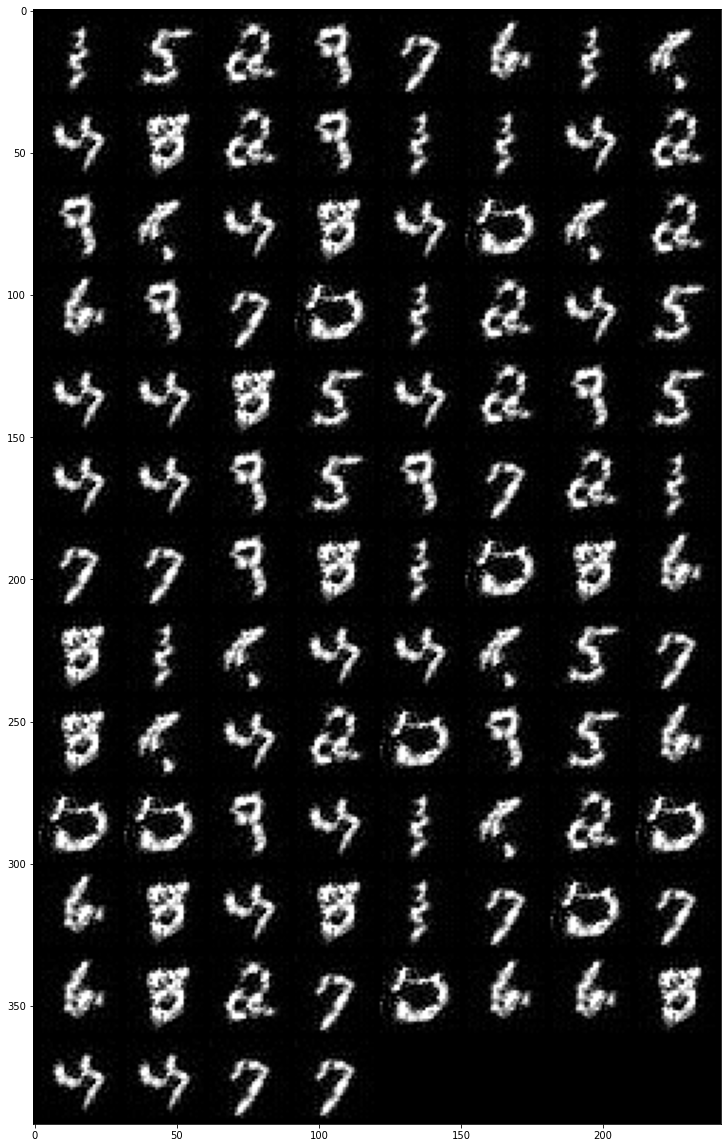

In [12]:
utils.save_image(fake_image, 'fake.png')
img = cv2.imread('fake.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 20.5)
plt.imshow(img)
plt.show()

**Corresponding Real Images**

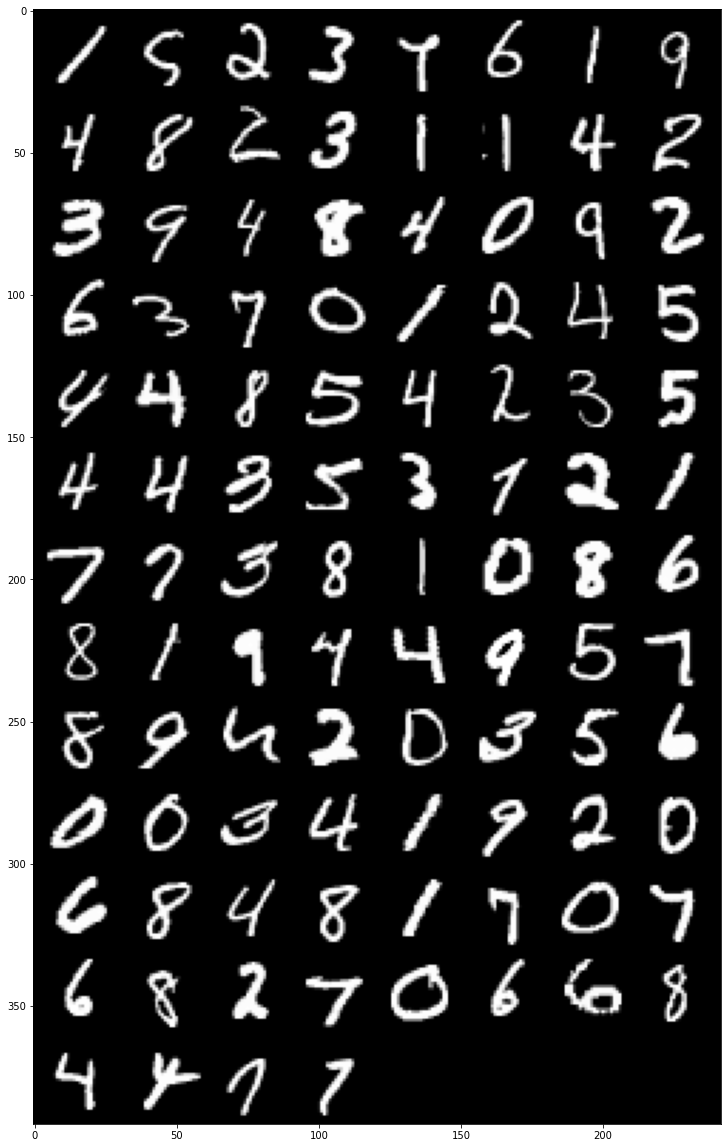

In [13]:
utils.save_image(real_image, 'real.png')
img = cv2.imread('real.png')
fig = plt.gcf()
fig.set_size_inches(18.5, 20.5)
plt.imshow(img)
plt.show()